# Exploratory Data Analysis and Hypothesis Testing

Before statiscal testing for the hypotheses, EDA will be conducted to better understand and visualize the nature of my data.

### Importing and Setting the Libraries, Preparing the Data
The following libraries must be used in order to read data from JSON files, manipulate and visualize the data.

In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set(style='whitegrid')

Set the path and read all the JSON files. Read all data into `games` list.

In [80]:
directory_path = Path("")
json_files = list(directory_path.glob("*.json"))

games = []
for file_path in json_files:
    with open(file_path, "r") as file:
        data = json.load(file)
        games.extend(data["games"])

To include the time data for each move, we need to extract it from the PGN of each game. Function `extract_move_times` extracts the timestamps of my each move, which is given in format of how much time is left in the clock. Then by subtracting the time value at a particular move from the previous move's time value, we get the time spent on that particular move.

We create a list for storing the time spent for the moves in the respective indices of the list.

_For Example: `times_seconds = [0, 1.1, 1.3, 4.5, 2.2]` implies the 1st move is done immediately, the 2nd move is completed in 1.1 seconds, the 3rd move is completed in 1.3 seconds, and so on. Note that these **my** data only._

In [81]:
import re

def extract_move_times(row):

    pgn = row['pgn']
    try:
      timecontrol = float(row['time_control'])
    except:
      return [];
    prevtime = timecontrol
    if row["white"]["username"] == "MrEKO0": # My username.
        side = "white"
    else:
        side = "black"

    # Assistance from ChatGPT for the usage of the "re" library for extracting time data.
    # This regex pattern finds move times enclosed in brackets, like {[%clk 0:01:00]}
    times = re.findall(r'\{\[%clk ([^\]]+)\]\}', pgn)

    # Convert the times to seconds and select only my move times and not my opponent's
    times_seconds = []
    for i, time_str in enumerate(times):
        if (side == 'white' and (i % 2 == 0)) or \
           (side == 'black' and (i % 2 != 0)):  # Check if it's my turn
            # Handle time strings with hours, minutes, and seconds
            time_parts = list(map(float, time_str.split(':')))
            if len(time_parts) == 2:  # If only minutes and seconds are present
                minutes, seconds = time_parts
            elif len(time_parts) == 3:  # If hours, minutes, and seconds are present
                hours, minutes, seconds = time_parts
                minutes = hours * 60 + minutes # Convert hours to minutes for calculation
            else:
                # Handle unexpected time string formats (if any)
                print(f"Warning: Unexpected time string format: {time_str}")
                continue  # Skip to the next time string
            total_seconds = minutes * 60 + seconds
            times_seconds.append(prevtime - total_seconds) # Time spent on each move.
            prevtime = total_seconds
    return times_seconds

We form the data frame with the data we got from the reading of JSON files, and the data we will be extracting with the function `extract_move_times` we created.

In [82]:
records = []
for game in games:
    if game["white"]["username"] == "MrEKO0":
      result = game["white"]["result"]
      side = "white"
    else:
      result = game["black"]["result"]
      side = "black"
    records.append({
        "side" : side, # With which pieces I am playing? Either black or white.
        "move_times" : extract_move_times(game), # Use the function to get list for each game.
        "pgn" : game["pgn"], # Include the raw PGN too in case of for further use.
        "result": result, # Win, checkmated, timeout...
        "time_class": game["time_class"], # Blitz, bullet, rapid.
        "time_control": game["time_control"] # 600, 300, 180 etc. (in seconds)
    })

df = pd.DataFrame(records)
df.head()

,side,move_times,pgn,result,time_class,time_control
0,white,"[3.4000000000000057, 2.299999999999983, 1.2000...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,blitz,180
1,black,"[0.8000000000000114, 0.6999999999999886, 0.800...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",win,blitz,180
2,black,"[2.4000000000000057, 0.5999999999999943, 1.0, ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,blitz,180
3,white,"[0.8000000000000114, 1.1999999999999886, 0.800...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,blitz,180
4,black,"[1.5999999999999943, 0.8000000000000114, 0.900...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,blitz,180


Empty lists to later store data according to `time_class` separately. We need to do this for plotting since `move_times` data of each game is in list format and difficult to use in plotting.

In [83]:
all_move_numbers_win = []
all_move_times_win = []
all_move_numbers_loss = []
all_move_times_loss = []

blitz_move_numbers_win = []
blitz_move_times_win = []
blitz_move_numbers_loss = []
blitz_move_times_loss = []

bullet_move_numbers_win = []
bullet_move_times_win = []
bullet_move_numbers_loss = []
bullet_move_times_loss = []

rapid_move_numbers_win = []
rapid_move_times_win = []
rapid_move_numbers_loss = []
rapid_move_times_loss = []

Fill the lists with move numbers (the indices), and time spent.

In [84]:
for index, row in df.iterrows():
    move_times_list = row['move_times']
    result = row['result']
    time_class = row['time_class']

    for i, move_time in enumerate(move_times_list): # Iterate over indexes and time values.
        if result == 'win': # The games I won.
            all_move_numbers_win.append(i + 1) # Moves start from 1.
            all_move_times_win.append(move_time)
            if time_class == 'blitz':
                blitz_move_numbers_win.append(i + 1)
                blitz_move_times_win.append(move_time)
            elif time_class == 'bullet':
                bullet_move_numbers_win.append(i + 1)
                bullet_move_times_win.append(move_time)
            elif time_class == 'rapid':
                rapid_move_numbers_win.append(i + 1)
                rapid_move_times_win.append(move_time)
        elif result in ('checkmated', 'resigned', 'timeout', 'abandoned'): # Lost games.
            all_move_numbers_loss.append(i + 1)
            all_move_times_loss.append(move_time)
            if time_class == 'blitz':
                blitz_move_numbers_loss.append(i + 1)
                blitz_move_times_loss.append(move_time)
            elif time_class == 'bullet':
                bullet_move_numbers_loss.append(i + 1)
                bullet_move_times_loss.append(move_time)
            elif time_class == 'rapid':
                rapid_move_numbers_loss.append(i + 1)
                rapid_move_times_loss.append(move_time)

### EDA and Visualization

We will visualize our data to uncover possible correlations, to evaluate and form initial reflections.

<ipython-input-85-e035195d3ad0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='time_class', palette = 'Set2')


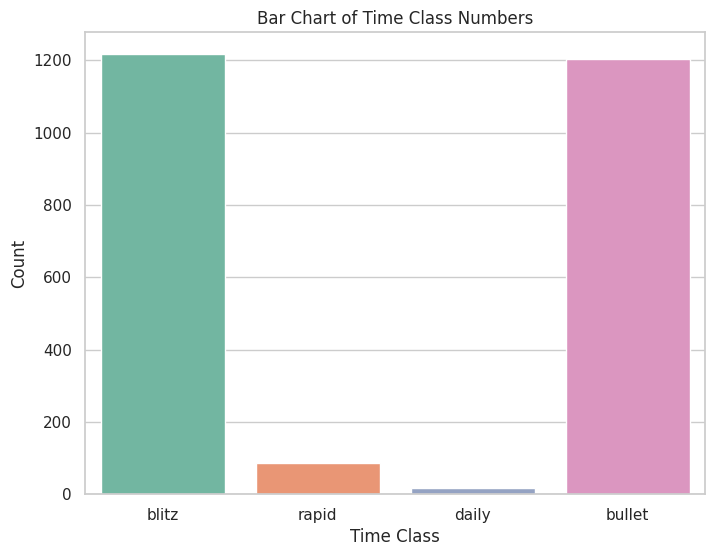

In [85]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='time_class', palette = 'Set2')
plt.title('Bar Chart of Time Class Numbers')
plt.xlabel('Time Class')
plt.ylabel('Count')
plt.show()

In our data, we have a very low amount of *daily* games. It would be better to exclude *daily* games from our analysis; since there is less data regarding it, and the outcomes/timings of them are often complex and confusing, not appropriate for driving general information.

Visualize which piece I am playing with, in how many games.

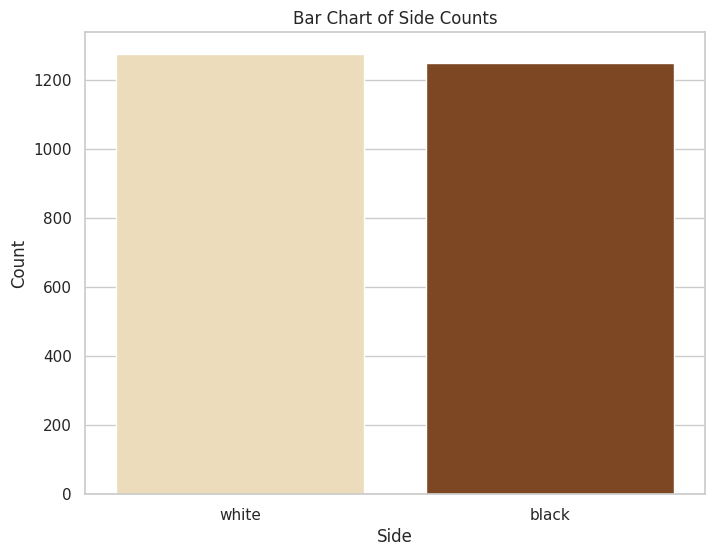

In [86]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='side', palette= ['Wheat', 'Saddlebrown'], hue = 'side', legend = False)
plt.title('Bar Chart of Side Counts')
plt.xlabel('Side')
plt.ylabel('Count')
plt.show()

Game Results Frequency

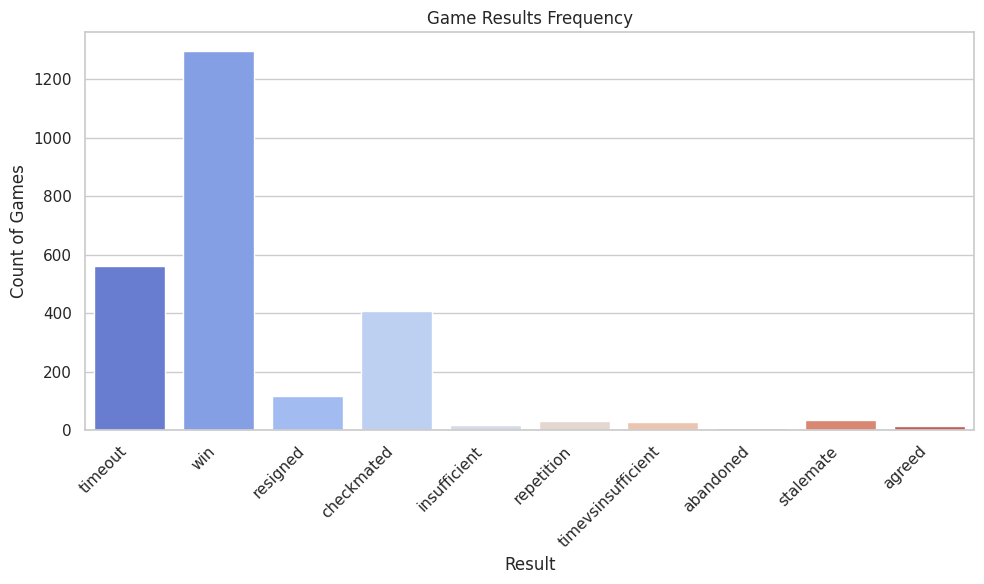

In [87]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='result', hue ='result', palette = 'coolwarm', legend = False)
plt.title('Game Results Frequency')
plt.xlabel('Result')
plt.ylabel('Count of Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Box plot for relation between Time Spent per Move and the Outcome of the Game (win-loss)

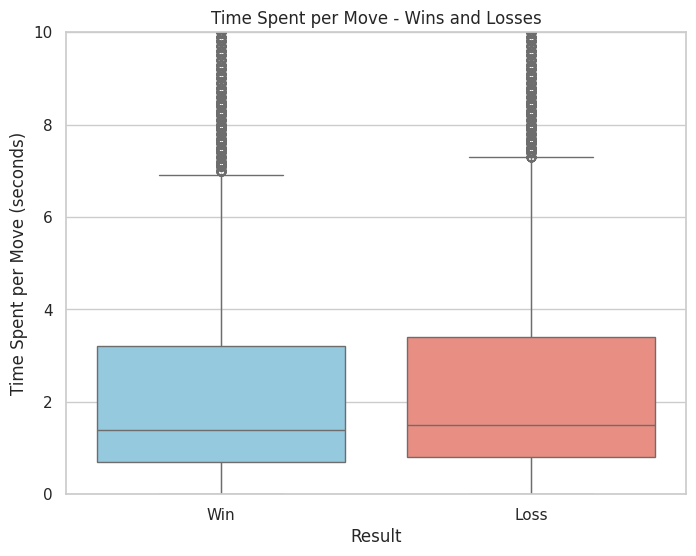

In [88]:
df1 = pd.DataFrame({
    'Move Time (seconds)': all_move_times_win + all_move_times_loss,
    'Result': ['Win'] * len(all_move_times_win) + ['Loss'] * len(all_move_times_loss)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Result', y='Move Time (seconds)', data=df1, palette=['skyblue', 'salmon'], hue='Result', legend=False)
plt.title('Time Spent per Move - Wins and Losses')
plt.xlabel('Result')
plt.ylabel('Time Spent per Move (seconds)')
plt.ylim(0, 10)
plt.grid(True)
plt.show()

Loss games appear to have a higher average of time spent per move, compared to win games. While both Win and Loss games have many outliers. Outliers indicate there exists moves I spent much time compared to other moves. In our case we must also take account of these moves, because they are not extreme values, but rather moves that will occur in any game.

Calculate "Average Move Time per Game" for each game: Simply by dividing the sum of the time spent to complete each move in a game, to the move length of the game.

In [89]:
df['avg_move_time'] = df['move_times'].apply(lambda x: sum(x) / len(x) if x else 0)

Let us create a histogram to display the distribution of the averages. Also I will enable `kde` to visualize a smooth, best-fit curve representing the densities.

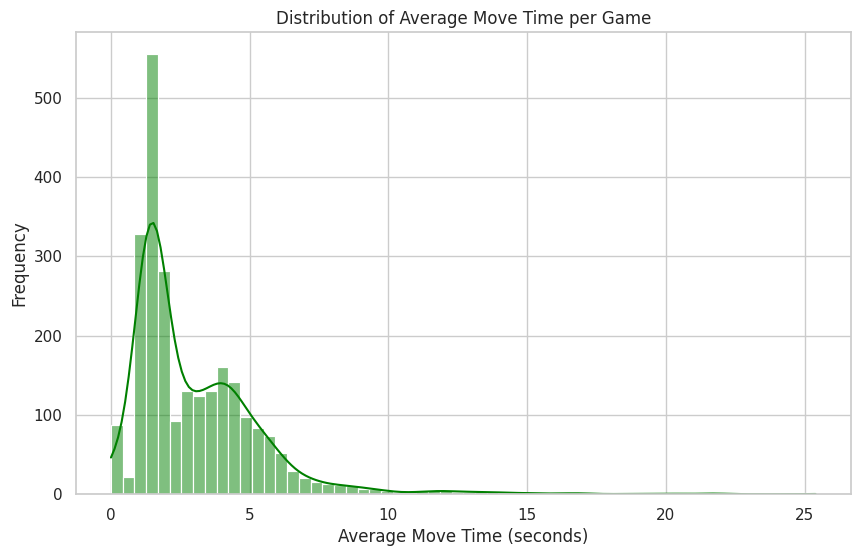

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_move_time'], kde=True, bins=60, color='green')
plt.title("Distribution of Average Move Time per Game")
plt.xlabel("Average Move Time (seconds)")
plt.ylabel("Frequency")
plt.show()

We must note that the remarkable frequency of averages near 0 can be caused by reasons including:

- **Premoves:** Premoves are moves I made during my opponent's turn. The move is executed automatically - typically in less than a second, once it's my turn. This is mainly because either I predict the next move of my opponent, or I have very low time left on the clock.

- **Fast-Paced Games:** Especially Bullet Games are very fast-paced and generally it contains many moves that are made in a blink time, along with many premoves.

Now let's compare Win and Loss games.

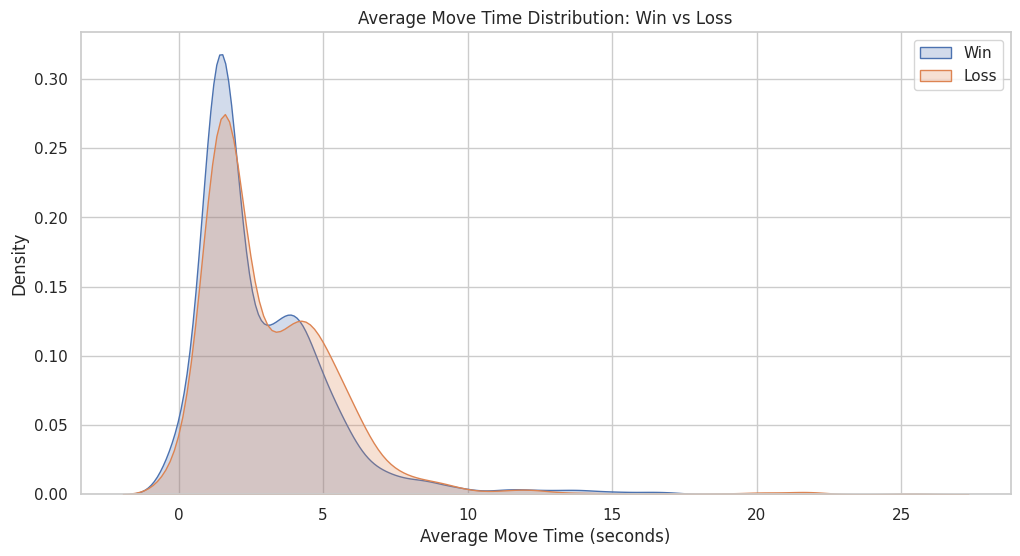

In [113]:
df_win = df[df['result'] == 'win']
df_loss = df[df['result'].isin(['checkmated', 'resigned', 'timeout', 'abandoned'])]

plt.figure(figsize=(12, 6))
sns.kdeplot(df_win['avg_move_time'], label='Win', fill=True)
sns.kdeplot(df_loss['avg_move_time'], label='Loss', fill=True)
plt.legend()
plt.title("Average Move Time Distribution: Win vs Loss")
plt.xlabel("Average Move Time (seconds)")
plt.show()

Create scatter plot for **All Games**

The time spent on a particular move. The *x-axis* is the move no's (1st move, 2nd move, and so on) and the *y-axis* is the time spent on making that particular move.

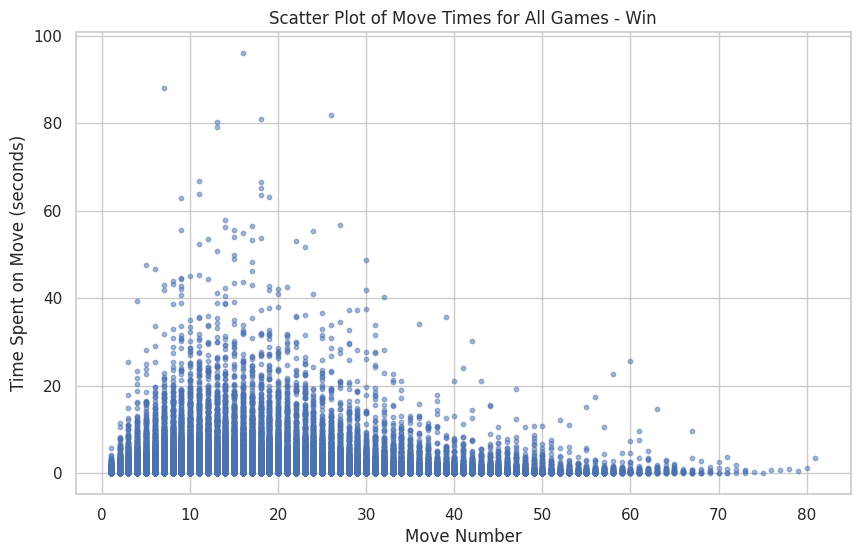

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(all_move_numbers_win, all_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for All Games - Win')
plt.grid(True)
plt.show()

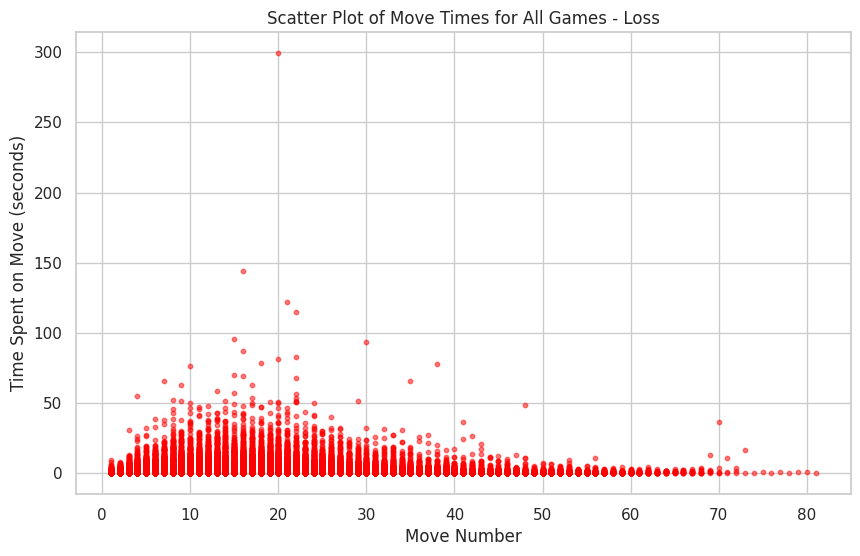

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(all_move_numbers_loss, all_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for All Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Blitz Games**

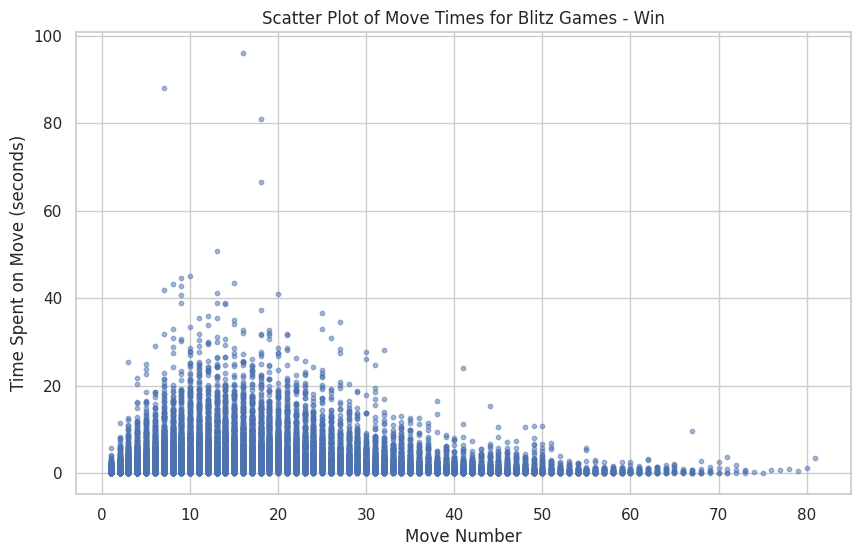

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(blitz_move_numbers_win, blitz_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Blitz Games - Win')
plt.grid(True)
plt.show()

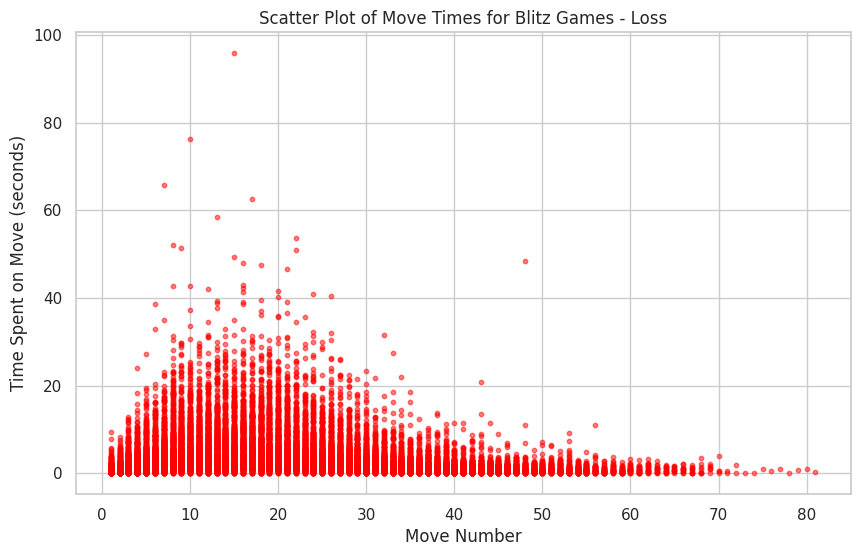

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(blitz_move_numbers_loss, blitz_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Blitz Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Bullet Games**

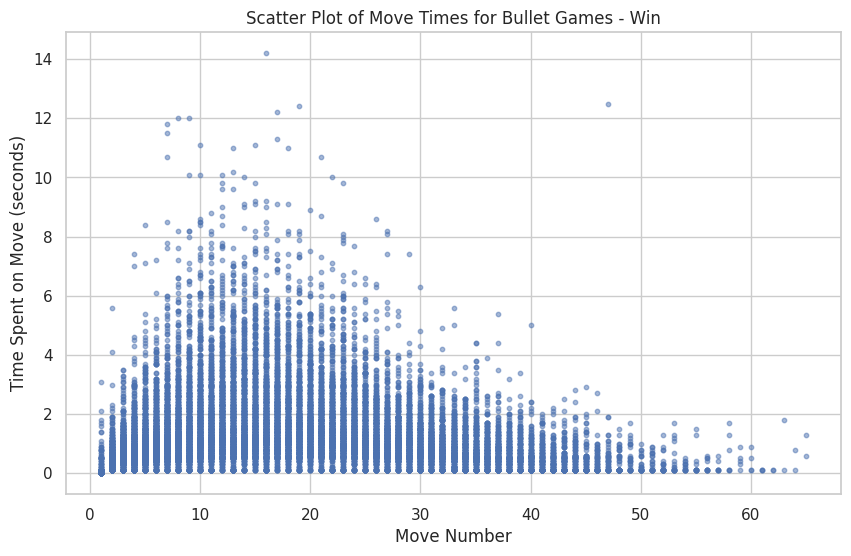

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(bullet_move_numbers_win, bullet_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Bullet Games - Win')
plt.grid(True)
plt.show()

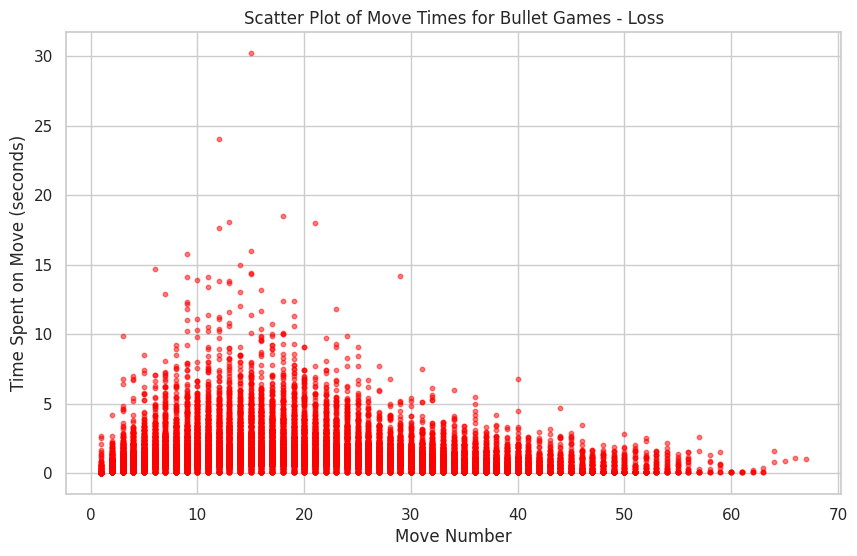

In [96]:
plt.figure(figsize=(10, 6))
plt.scatter(bullet_move_numbers_loss, bullet_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Bullet Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Rapid Games**

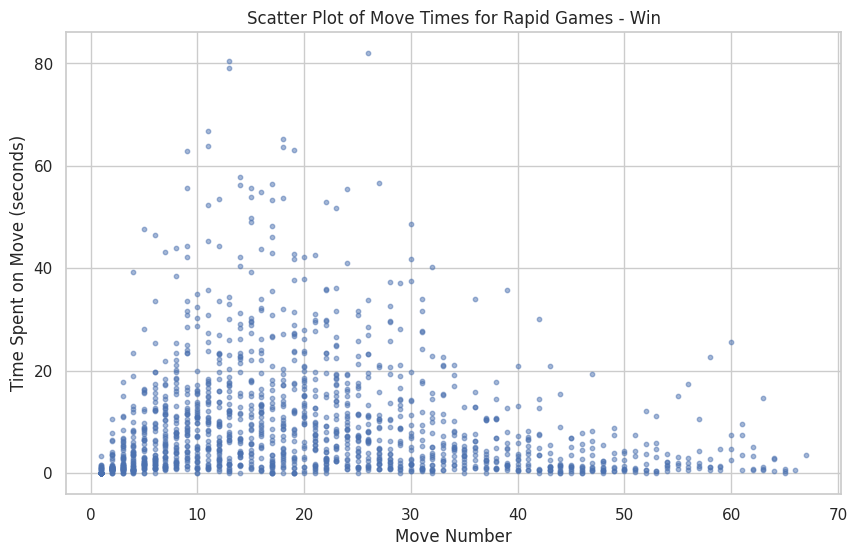

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(rapid_move_numbers_win, rapid_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Rapid Games - Win')
plt.grid(True)
plt.show()

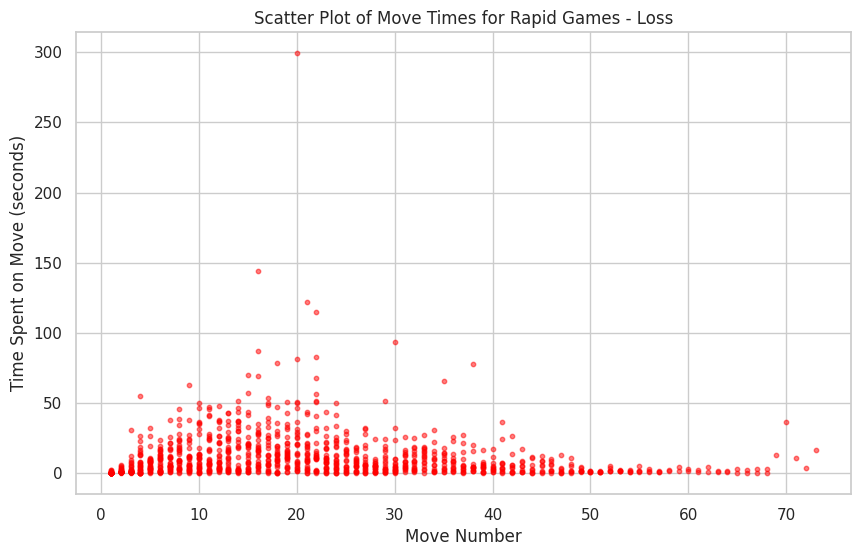

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(rapid_move_numbers_loss, rapid_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Rapid Games - Loss')
plt.grid(True)
plt.show()

### Hypothesis Testing
**Null Hypothesis (H₀):** There is no distinct, unique pattern in the time I spend on each move in the games I won when the moves of the whole game are divided into equal phases. The time distribution pattern in winning games does not differ significantly from the time distribution pattern observed in games I lost. Any observed difference between winning and losing games is due to random variation rather than consistent patterns.

**Alternative Hypothesis (H₁):** The time I spend on each move in the games I won follows a unique, distinct pattern when the moves of the whole game are divided into equal phases, and this pattern differs significantly from the time distribution pattern observed in games I lost.

In [99]:
from scipy import stats

For convenience and better testing, we will separate games according to their categories: All, Blitz, Bullet, Rapid.

In the following code we generate dictionaries with keys being the move no's and values being the time spent data combined for that particular move.

We will conduct two sample t-test's for each move separately. This is because each move is a discrete variable. We will then come up with a general idea.

In [107]:
# Dictionaries for move data. Keys are move no's.
move_win_dict = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(all_move_times_win, all_move_numbers_win):
    if move_number in move_win_dict:
        move_win_dict[move_number].append(move_time)

# Loss
for move_time, move_number in zip(all_move_times_loss, all_move_numbers_loss):
    if move_number in move_loss_dict:
        move_loss_dict[move_number].append(move_time)

count = 0
for move_number in range(1, 75): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict[move_number], move_loss_dict[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -2.8211112585435996 p_value: 0.004835902554799698
Move Number: 2 t-stat: 0.10947677799473543 p_value: 0.9128338863901837
Move Number: 3 t-stat: -1.0935996613007202 p_value: 0.2742503567185655
Move Number: 4 t-stat: -1.3436415811932783 p_value: 0.17921091580300924
Move Number: 5 t-stat: -0.9169779465429604 p_value: 0.35925240801588076
Move Number: 6 t-stat: -2.0828215973577953 p_value: 0.03738220990840226
Move Number: 7 t-stat: -0.9338137489160748 p_value: 0.3505001168445798
Move Number: 8 t-stat: -2.7296316371585596 p_value: 0.00639522917551717
Move Number: 9 t-stat: -1.4350311789040213 p_value: 0.15141916842372488
Move Number: 10 t-stat: -1.598823963007348 p_value: 0.11001554127149912
Move Number: 11 t-stat: -0.5432680031493181 p_value: 0.5870001977741048
Move Number: 12 t-stat: -2.2006738777914623 p_value: 0.027868681304574285
Move Number: 13 t-stat: -1.8540364903055464 p_value: 0.06387154485972878
Move Number: 14 t-stat: -1.4841105926140195 p_value: 0.13793167

Out of 73 successful t-tests, we observed only 15 p-values that are smaller than our significance level of 5%. This suggest that there is no significant evidence to reject the Null Hypothesis for **All Games**.

We **fail** to reject the Null Hypothesis for this category.

Now let's test for each category separately.

We will examine the **Blitz Games**

In [108]:
# Dictionaries for move data. Keys are move no's.
move_win_dict1 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict1 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(blitz_move_times_win, blitz_move_numbers_win):
    if move_number in move_win_dict1:
        move_win_dict1[move_number].append(move_time)

# Loss
for move_time, move_number in zip(blitz_move_times_loss, blitz_move_numbers_loss):
    if move_number in move_loss_dict1:
        move_loss_dict1[move_number].append(move_time)

count = 0
p_values = []
for move_number in range(1, 75): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict1[move_number], move_loss_dict1[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")
  p_values.append(p_value)
print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -3.078403237979571 p_value: 0.0021476429068566436
Move Number: 2 t-stat: -0.06983983354626057 p_value: 0.9443343066571164
Move Number: 3 t-stat: -0.7090403817807465 p_value: 0.478456429327472
Move Number: 4 t-stat: -0.7611396485428634 p_value: 0.4467475680499111
Move Number: 5 t-stat: -0.9644043610690886 p_value: 0.33507099990163525
Move Number: 6 t-stat: -2.657364057503398 p_value: 0.008006885060294369
Move Number: 7 t-stat: -0.9229806287803735 p_value: 0.3562293662097751
Move Number: 8 t-stat: -3.1775251408170737 p_value: 0.001534593560959056
Move Number: 9 t-stat: -2.7241265903697434 p_value: 0.006560359511964862
Move Number: 10 t-stat: -1.6855548432533198 p_value: 0.09220836207264804
Move Number: 11 t-stat: -0.8666901767534947 p_value: 0.38631892997389916
Move Number: 12 t-stat: -2.5042163271256124 p_value: 0.012437752909544509
Move Number: 13 t-stat: -2.294295198925073 p_value: 0.02199176027719
Move Number: 14 t-stat: -1.3406407589787814 p_value: 0.180362669

Out of 72 successful tests, we observe 23 p-values that are smaller than the significance level. Although this suggests we **fail** to reject the Null Hypothesis, there are still 23 moves that follow a different pattern between Won and Loss games.

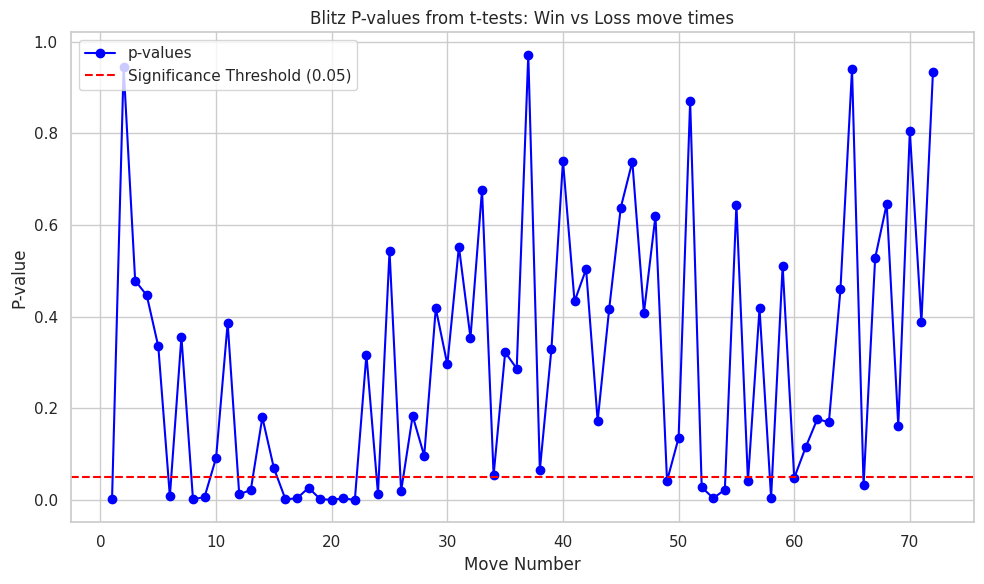

In [102]:
move_numbers = list(range(1, 75))

plt.figure(figsize=(10, 6))
plt.plot(move_numbers, p_values, marker='o', linestyle='-', color='blue', label='p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Blitz P-values from t-tests: Win vs Loss move times')
plt.xlabel('Move Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe, between moves 1-20, more p-values yields results suggesting a difference. Also we can clearly see between moves 50-60 the p-values are more focused, which might suggest a pattern difference. We may conclude that for **Blitz Games** although we **fail** to reject the Null Hypothesis overall, if we examine spesific move intervals we can observe patterns that support the Alternative Hypothesis.

Now, we will examine the **Bullet Games**

In [109]:
# Dictionaries for move data. Keys are move no's.
move_win_dict2 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict2 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(bullet_move_times_win, bullet_move_numbers_win):
    if move_number in move_win_dict2:
        move_win_dict2[move_number].append(move_time)

# Loss
for move_time, move_number in zip(bullet_move_times_loss, bullet_move_numbers_loss):
    if move_number in move_loss_dict2:
        move_loss_dict2[move_number].append(move_time)

count = 0
p_values1 = []
for move_number in range(1, 66): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict2[move_number], move_loss_dict2[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  p_values1.append(p_value)
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -0.30972990566538844 p_value: 0.7568238260011301
Move Number: 2 t-stat: -0.6050553973877029 p_value: 0.5452617512792507
Move Number: 3 t-stat: -2.800518764291551 p_value: 0.005209495243992218
Move Number: 4 t-stat: -1.5011718782947618 p_value: 0.13359800664332397
Move Number: 5 t-stat: -1.5760298370225065 p_value: 0.1153133463886722
Move Number: 6 t-stat: -2.239204305140437 p_value: 0.025361405677524183
Move Number: 7 t-stat: -1.0419140868705528 p_value: 0.2976779342385536
Move Number: 8 t-stat: -0.9021583369663576 p_value: 0.3671696219296565
Move Number: 9 t-stat: -1.9600863916292721 p_value: 0.050267163960890766
Move Number: 10 t-stat: -0.27705062103280353 p_value: 0.7817929519351521
Move Number: 11 t-stat: -2.1571923985597605 p_value: 0.031223595089080437
Move Number: 12 t-stat: -1.4612538590414348 p_value: 0.1442739073685676
Move Number: 13 t-stat: -1.9667764245230321 p_value: 0.04948517361453368
Move Number: 14 t-stat: -2.559265115832575 p_value: 0.010633210

Out of 64 successful t-tests, we observe 23 p-values that suggest a difference. This is a similar result to what we obtain from the Blitz Games. Let's plot the p-values for further examination.

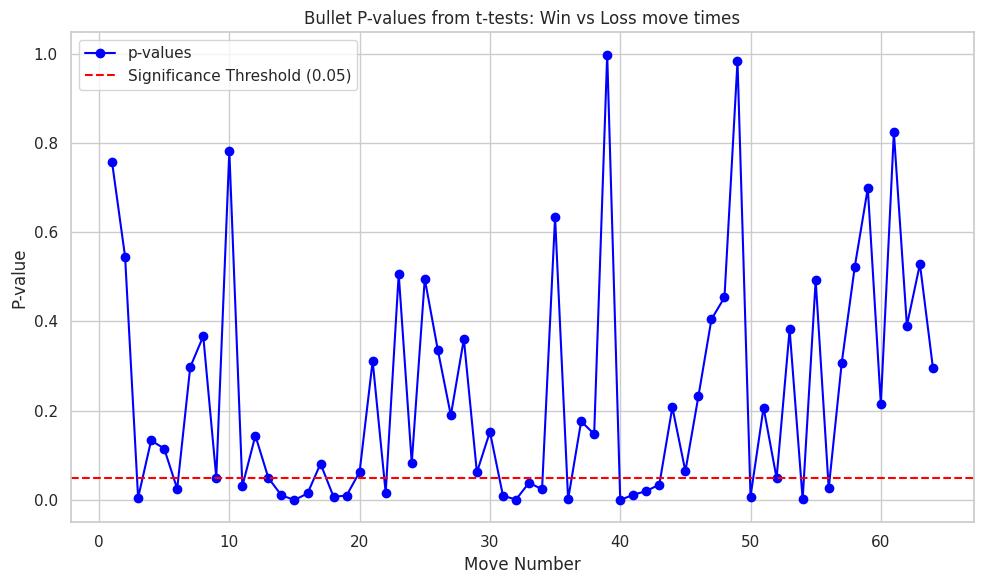

In [104]:
move_numbers = list(range(1, 66))

plt.figure(figsize=(10, 6))
plt.plot(move_numbers, p_values1, marker='o', linestyle='-', color='blue', label='p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Bullet P-values from t-tests: Win vs Loss move times')
plt.xlabel('Move Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot suggests that for **Bullet Games** just like the Blitz Games, there are significant differences between Won and Loss games in spesific intervals.

We conclude, for **Bullet Games** we **fail** to reject the Null Hypothesis.

Note: We may suggest that there are intervals of moves that likely suggest a pattern, thus may yield results in favor of the Alternative Hypothesis.

Lastly, we will examine **Rapid Games**

In [110]:
# Dictionaries for move data. Keys are move no's.
move_win_dict3 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict3 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(rapid_move_times_win, rapid_move_numbers_win):
    if move_number in move_win_dict3:
        move_win_dict3[move_number].append(move_time)

# Loss
for move_time, move_number in zip(rapid_move_times_loss, rapid_move_numbers_loss):
    if move_number in move_loss_dict3:
        move_loss_dict3[move_number].append(move_time)

count = 0
for move_number in range(1, 68): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict3[move_number], move_loss_dict3[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -0.5422833918574405 p_value: 0.5896396334851387
Move Number: 2 t-stat: 0.21063055014811502 p_value: 0.8337461730722026
Move Number: 3 t-stat: -0.2702791156842888 p_value: 0.7882010997658611
Move Number: 4 t-stat: -1.584419656276458 p_value: 0.1203977120328122
Move Number: 5 t-stat: -0.5547399452284447 p_value: 0.5808922053765508
Move Number: 6 t-stat: -0.053337155120408625 p_value: 0.9576072872080217
Move Number: 7 t-stat: -0.9334001801249574 p_value: 0.35479379096425734
Move Number: 8 t-stat: -1.4274989738359523 p_value: 0.1595199939798892
Move Number: 9 t-stat: 1.009358571613399 p_value: 0.3166905009920734
Move Number: 10 t-stat: -1.502996557081128 p_value: 0.1405885000729951
Move Number: 11 t-stat: 0.07899721908352432 p_value: 0.9372812739209819
Move Number: 12 t-stat: -0.9444250403987872 p_value: 0.3491712148759345
Move Number: 13 t-stat: -0.23570531368893938 p_value: 0.8143714144851736
Move Number: 14 t-stat: -0.8874246060210933 p_value: 0.3788123093091692
M

Out of 65 successful t-tests for each move of **Rapid Games** we observe only 2 significant p-values. This strongly suggests that even without the need of examining move intervals, we **fail** to reject the Null Hypothesis.

**Insights:**
- Although I failed to reject the Null Hypotheses, it is clear that there exists a pattern in spesific move intervals. These intervals may be examined to obtain a proving result to reject the Null Hypotheses, as a future work.

- There are significant differences in results between games of different time classes. This could be taken into consideration as a future work.

- It may be possible to predict game outcome during a continuing game, with applying ML methods. The pattern difference we found between moves 1-20 also support this idea. These early moves may be a strong indicator for the outcome.